In [3]:
import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds=preds[torch.randperm(len(preds))]
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


NameError: name 'cc' is not defined

../../../../data/pkegnn_INS/inputs/5gh9.npz
[b'1086A2' b'1088A4' b'1089A4' b'1099A4' b'1102A3' b'1105A1' b'1107A4'
 b'1116A1' b'1124A1' b'1125A3' b'1127A1' b'1130A2' b'1134A1' b'1139A2'
 b'1141A2' b'1143A1' b'1147A3' b'1149A4' b'1153A3' b'1155A1' b'1156A1'
 b'1167A3' b'1170A2' b'1175A3' b'1176A2' b'1178A5' b'1180A2' b'1183A4'
 b'1186A4' b'1188A4' b'1190A1' b'89B3']
tensor([ 0.6327, -0.9747, -0.2826, -0.3286,  0.8868, -0.2961, -0.3694, -0.3631,
        -1.6168,  1.5146,  0.0751,  0.3317, -0.7768,  1.3027,  1.0505, -0.2937,
         6.2964, -0.3765,  4.0661,  0.4666, -1.0420,  4.3691,  0.1661,  0.3567,
         0.1345,  3.6807,  0.9316, -0.5079,  0.2521,  0.1389, -0.3903,  0.4396])
../../../../data/pkegnn_INS/inputs/4pbx.npz
[b'101A1' b'102A4' b'105A3' b'106A4' b'115A4' b'119A0' b'121A2' b'127A4'
 b'128A1' b'138A1' b'144A2' b'147A4' b'163A1' b'165A4' b'170A2' b'171A1'
 b'176A1' b'185A2' b'195A4' b'198A4' b'199A4' b'201A1' b'204A2' b'205A3'
 b'206A4' b'217A3' b'224A3' b'241A0' b'242A4' b'

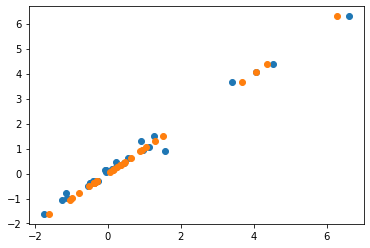

tensor(0.1451)


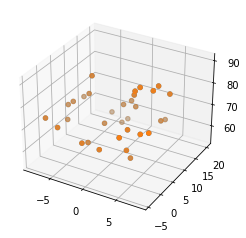

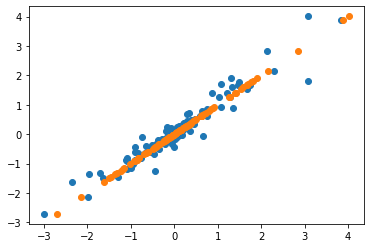

tensor(0.1982)


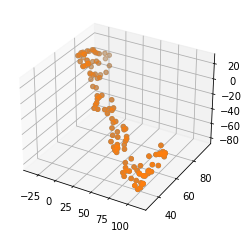

In [27]:
import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0), _                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #cantt shuffle here
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


../../../../data/pkegnn_INS/inputs/5gh9.npz
[b'1086A2' b'1088A4' b'1089A4' b'1099A4' b'1102A3' b'1105A1' b'1107A4'
 b'1116A1' b'1124A1' b'1125A3' b'1127A1' b'1130A2' b'1134A1' b'1139A2'
 b'1141A2' b'1143A1' b'1147A3' b'1149A4' b'1153A3' b'1155A1' b'1156A1'
 b'1167A3' b'1170A2' b'1175A3' b'1176A2' b'1178A5' b'1180A2' b'1183A4'
 b'1186A4' b'1188A4' b'1190A1' b'89B3']
tensor([ 0.6327, -0.9747, -0.2826, -0.3286,  0.8868, -0.2961, -0.3694, -0.3631,
        -1.6168,  1.5146,  0.0751,  0.3317, -0.7768,  1.3027,  1.0505, -0.2937,
         6.2964, -0.3765,  4.0661,  0.4666, -1.0420,  4.3691,  0.1661,  0.3567,
         0.1345,  3.6807,  0.9316, -0.5079,  0.2521,  0.1389, -0.3903,  0.4396])
../../../../data/pkegnn_INS/inputs/4pbx.npz
[b'101A1' b'102A4' b'105A3' b'106A4' b'115A4' b'119A0' b'121A2' b'127A4'
 b'128A1' b'138A1' b'144A2' b'147A4' b'163A1' b'165A4' b'170A2' b'171A1'
 b'176A1' b'185A2' b'195A4' b'198A4' b'199A4' b'201A1' b'204A2' b'205A3'
 b'206A4' b'217A3' b'224A3' b'241A0' b'242A4' b'

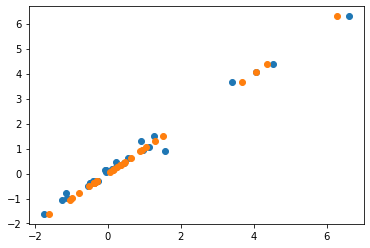

tensor(0.1451)


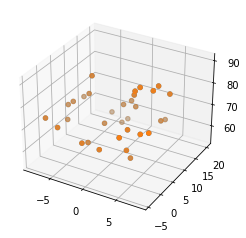

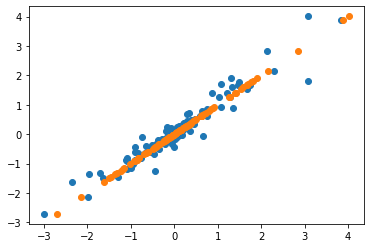

tensor(0.1982)


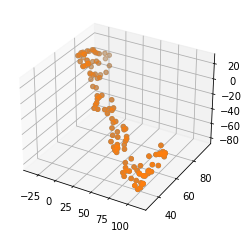

In [52]:
import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:

            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            m=torch.randperm(len(z_res))
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            #y_res=y_res[m].to(device)
            #centroids=centroids.squeeze(0)[m].unsqueeze(0)#4#
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #cantt shuffle here
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


../../../../data/pkegnn_INS/inputs/5gh9.npz
[b'1086A2' b'1088A4' b'1089A4' b'1099A4' b'1102A3' b'1105A1' b'1107A4'
 b'1116A1' b'1124A1' b'1125A3' b'1127A1' b'1130A2' b'1134A1' b'1139A2'
 b'1141A2' b'1143A1' b'1147A3' b'1149A4' b'1153A3' b'1155A1' b'1156A1'
 b'1167A3' b'1170A2' b'1175A3' b'1176A2' b'1178A5' b'1180A2' b'1183A4'
 b'1186A4' b'1188A4' b'1190A1' b'89B3']
tensor([ 0.6327, -0.9747, -0.2826, -0.3286,  0.8868, -0.2961, -0.3694, -0.3631,
        -1.6168,  1.5146,  0.0751,  0.3317, -0.7768,  1.3027,  1.0505, -0.2937,
         6.2964, -0.3765,  4.0661,  0.4666, -1.0420,  4.3691,  0.1661,  0.3567,
         0.1345,  3.6807,  0.9316, -0.5079,  0.2521,  0.1389, -0.3903,  0.4396])
../../../../data/pkegnn_INS/inputs/4pbx.npz
[b'101A1' b'102A4' b'105A3' b'106A4' b'115A4' b'119A0' b'121A2' b'127A4'
 b'128A1' b'138A1' b'144A2' b'147A4' b'163A1' b'165A4' b'170A2' b'171A1'
 b'176A1' b'185A2' b'195A4' b'198A4' b'199A4' b'201A1' b'204A2' b'205A3'
 b'206A4' b'217A3' b'224A3' b'241A0' b'242A4' b'

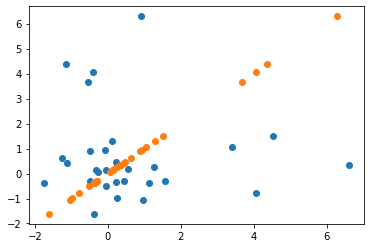

tensor(1.7795)


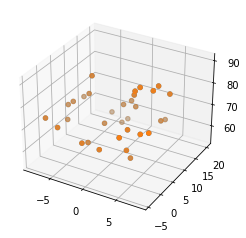

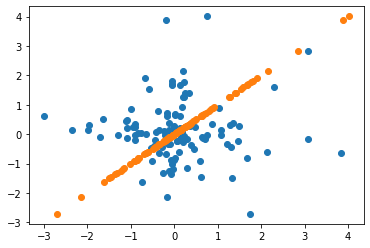

tensor(1.0876)


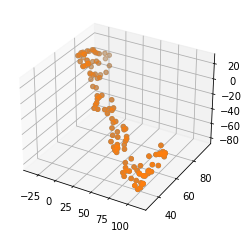

In [53]:
import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:

            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            m=torch.randperm(len(z_res))
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            y_res=y_res[m].to(device)
            #centroids=centroids.squeeze(0)[m].unsqueeze(0)#4#
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #cantt shuffle here
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


../../../../data/pkegnn_INS/inputs/5gh9.npz
[b'1086A2' b'1088A4' b'1089A4' b'1099A4' b'1102A3' b'1105A1' b'1107A4'
 b'1116A1' b'1124A1' b'1125A3' b'1127A1' b'1130A2' b'1134A1' b'1139A2'
 b'1141A2' b'1143A1' b'1147A3' b'1149A4' b'1153A3' b'1155A1' b'1156A1'
 b'1167A3' b'1170A2' b'1175A3' b'1176A2' b'1178A5' b'1180A2' b'1183A4'
 b'1186A4' b'1188A4' b'1190A1' b'89B3']
tensor([ 0.6327, -0.9747, -0.2826, -0.3286,  0.8868, -0.2961, -0.3694, -0.3631,
        -1.6168,  1.5146,  0.0751,  0.3317, -0.7768,  1.3027,  1.0505, -0.2937,
         6.2964, -0.3765,  4.0661,  0.4666, -1.0420,  4.3691,  0.1661,  0.3567,
         0.1345,  3.6807,  0.9316, -0.5079,  0.2521,  0.1389, -0.3903,  0.4396])
../../../../data/pkegnn_INS/inputs/4pbx.npz
[b'101A1' b'102A4' b'105A3' b'106A4' b'115A4' b'119A0' b'121A2' b'127A4'
 b'128A1' b'138A1' b'144A2' b'147A4' b'163A1' b'165A4' b'170A2' b'171A1'
 b'176A1' b'185A2' b'195A4' b'198A4' b'199A4' b'201A1' b'204A2' b'205A3'
 b'206A4' b'217A3' b'224A3' b'241A0' b'242A4' b'

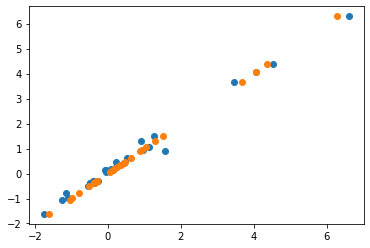

tensor(0.1431)


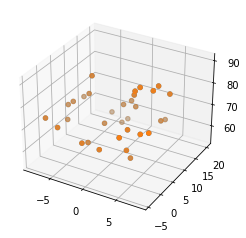

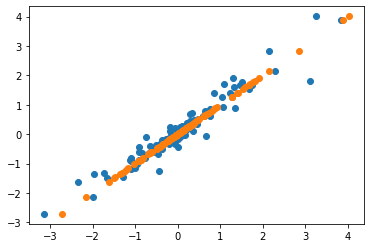

tensor(0.1980)


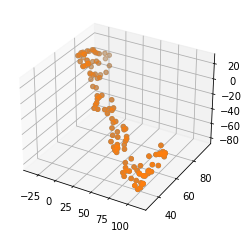

In [54]:
import torch
import numpy as np
import glob
p=glob.glob("../../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:

            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            m=torch.randperm(len(z_res))
            feats, centroids = forward_residues(z_res[m], x_res[m])         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            y_res=y_res[m].to(device)
            #centroids=centroids.squeeze(0)[m].unsqueeze(0)#4#
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #cantt shuffle here
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


In [189]:
import torch
import numpy as np
import glob
p=glob.glob("../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x,m):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.00):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:2] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r,m):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r,m)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)
    #h=h[m]
    #coords=coords[m]
    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)    ##extremely perm var                 # (R, N, N, basis)
    print(rbf.shape)
    
    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)  #almost invar             # (R, dim,   N)
    print(h0.shape)
    r0  = rbf.transpose(1, 2)  
    print(r0.shape)     # (R, basis, N) #crazy perm
    #tok = torch.cat((r0, h0), dim=1) #invar    # (R, dim+basis#m here, N)#m here is eq eff to 
    #print(pred_head(h0).shape,pred_head(r0).shape)
    #print(nconv(r0).shape)
    tok, _ = mha_layer(tok.permute(2, 0, 1)) #invar
    
    #tok=tok   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device) #invar
    #tok=tok #invar
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                             # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:

            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            m=torch.randperm(len(z_res))
            feats, centroids = forward_residues(z_res, x_res,m)         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            y_res=y_res[m].to(device)
            centroids=centroids.squeeze(0)[m].unsqueeze(0)#4#
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))   #yes
            #preds=preds[m]  #yes
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            #protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids) #so then yes
            preds=preds.permute(1,2,0)
            #
            #preds=preds[m]#invar
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device) #NO

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            cent=cent[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


../../../../data/pkegnn_INS/inputs/5gh9.npz
[b'1086A2' b'1088A4' b'1089A4' b'1099A4' b'1102A3' b'1105A1' b'1107A4'
 b'1116A1' b'1124A1' b'1125A3' b'1127A1' b'1130A2' b'1134A1' b'1139A2'
 b'1141A2' b'1143A1' b'1147A3' b'1149A4' b'1153A3' b'1155A1' b'1156A1'
 b'1167A3' b'1170A2' b'1175A3' b'1176A2' b'1178A5' b'1180A2' b'1183A4'
 b'1186A4' b'1188A4' b'1190A1' b'89B3']
tensor([ 0.6327, -0.9747, -0.2826, -0.3286,  0.8868, -0.2961, -0.3694, -0.3631,
        -1.6168,  1.5146,  0.0751,  0.3317, -0.7768,  1.3027,  1.0505, -0.2937,
         6.2964, -0.3765,  4.0661,  0.4666, -1.0420,  4.3691,  0.1661,  0.3567,
         0.1345,  3.6807,  0.9316, -0.5079,  0.2521,  0.1389, -0.3903,  0.4396])
../../../../data/pkegnn_INS/inputs/4pbx.npz
[b'101A1' b'102A4' b'105A3' b'106A4' b'115A4' b'119A0' b'121A2' b'127A4'
 b'128A1' b'138A1' b'144A2' b'147A4' b'163A1' b'165A4' b'170A2' b'171A1'
 b'176A1' b'185A2' b'195A4' b'198A4' b'199A4' b'201A1' b'204A2' b'205A3'
 b'206A4' b'217A3' b'224A3' b'241A0' b'242A4' b'

AssertionError: embed_dim must be divisible by num_heads

In [187]:
rconv=nn.Conv2d(100,1,8)
rconv(torch.rand([150, 100, 150, 8])).shape

torch.Size([150, 1, 143, 1])

In [152]:
nn.Linear(1,1)(torch.rand(100, 8, 32, 32).unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (25600x32 and 1x1)

In [170]:
a=torch.rand(32, 100, 32, 8) * torch.rand(100, 32, 8) 
a.shape

torch.Size([32, 100, 32, 8])

In [167]:
mha_layer(a)

RuntimeError: The size of tensor a (8) must match the size of tensor b (20) at non-singleton dimension 3

In [163]:
a

{'epoch': 901,
 'elapsed_min': 214.11568980614345,
 'net': OrderedDict([('blocks.0.egnn.token_emb.weight',
               tensor([[ 7.9760e-03,  2.7374e-03,  6.2486e-03,  ...,  3.3494e-03,
                         1.0214e-02,  1.8204e-03],
                       [ 1.0156e-02, -1.1688e-03,  9.3566e-03,  ...,  3.4257e-03,
                        -2.0064e-02, -4.3779e-03],
                       [ 3.0591e-04,  1.1165e-02, -5.9916e-03,  ...,  6.4024e-03,
                        -4.9101e-03, -1.1633e-02],
                       ...,
                       [-8.6734e-03, -5.3611e-03,  5.6191e-03,  ...,  3.6017e-04,
                        -4.7233e-03, -1.0412e-03],
                       [-7.7453e-04,  3.0019e-03,  1.3615e-05,  ..., -6.5572e-03,
                         8.4934e-05,  6.2792e-03],
                       [ 6.9056e-03,  2.8751e-03,  2.0228e-02,  ...,  4.9763e-03,
                         7.0987e-04, -5.2465e-03]])),
              ('blocks.0.egnn.pos_emb.weight',
               te

In [6]:
import torch
import numpy as np
import glob
p=glob.glob("../../../data/all_checkpoints/benchmark*.pt")
for c in p[-1:]:
    a=torch.load(c, map_location=torch.device('cpu'))
    m=a["mha"]
    e=a["net"]
    l1=a["lin"]
    #l2=a["lin2"]
    cc=a["convs"]
    r=a["rbf"]
    op=a["optimizer"]
    sc=a["scheduler"]
    pe=a["model"]
    
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=98,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 12, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=3 #scale to 2, at least
hidden_dim=4
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)
                ids=dat["ids"]
                print(p)
                print(ids)
                
                #print(dat["ids"])
                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
                print(y)
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)
    

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../../../../data/pkegnn_INS/inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
val_paths = all_paths[:10] #+# all_paths[5:15], all_paths[2:5]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
nconv.load_state_dict(cc[1])
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
conv.load_state_dict(cc[0])
#train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

#train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
#                          shuffle=True,  collate_fn=pad_collate,
#                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)
egnn_net.load_state_dict(e)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
rbf_layer.load_state_dict(r)
#rbf_layer.loa
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
mha_layer.load_state_dict(m)
pred_head = nn.Linear(1, 1).to(device)
pred_head.load_state_dict(l1)
#pred_head2 = nn.Linear(1, 1).to(device).load_state_dict(l2)

#protein_egnn=EGNN(dim=1,update_coors=False).load_state_dict(pe)
protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
protein_egnn.load_state_dict(pe)
criterion = nn.L1Loss()



optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
optimizer.load_state_dict(op)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
scheduler.load_state_dict(sc)

modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 1 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    
    tokk=nconv(tok.to(device).permute(1,0,2)).to(device)
    #torch.shuff
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tokk,     coords.mean(dim=1).unsqueeze(0), _, tok                              # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):

    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); #pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids, _, ou = forward_residues(z_res, x_res)         # (R, C)
            #m=torch.randperm(len(feats))
            #feats=feats[m]
            #cannot shuffle here########################
            #centroids=centroids[m]
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            #m=torch.randperm(len(t))
            #t=t[m]
            #centroids=centroids[m]#.unsqueeze(0)4#
            #can shuff
            preds, cent = protein_egnn(t, centroids)
            preds=preds.permute(1,2,0)
            #cantt shuffle here
            #preds=preds[torch.randperm(len(preds))]
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            from matplotlib import pyplot as plt
            #plt.plot(feats.flatten().detach().numpy())
            #plt.show()
            #plt.plot(preds.flatten().detach().numpy())

            #plt.plot(y_res.flatten().detach().numpy())
            #plt.show()
            plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
            plt.show()
            print(loss)
            for i in _.mean(dim=2):
                plt.plot(i)
            cent=cent[0]
            ch=centroids[0]
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            ax.scatter(cent[:, 0], cent[:, 1], cent[:, 2], label="Updated")
            #ch=centroids[0]
            plt.show()
            #fig = plt.figure()
            #ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(ch[:, 0], ch[:, 1], ch[:, 2], label="Updated")
                        


Whole model          : 36,800
{'runid': '20250724_065324', 'num_nbrs': 100, 'num_nbrs_egnn': 11, 'learning_rate': [1.0670104206950166e-06], 'dataset': ('../../../../data/pkegnn_INS/inputs/*.npz', 0), 'epochs': 1, 'dim': 12, 'depth': 3, 'basis': 8, 'hidden_dim': 4, 'num_heads': 20, 'dropout': [0.03, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 36800}


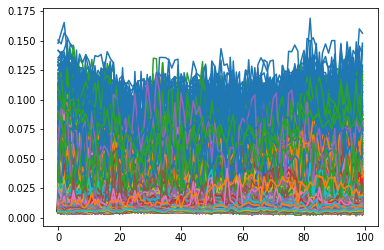

In [213]:
for i in _.mean(dim=0):
    plt.plot(i)
    #print(i)

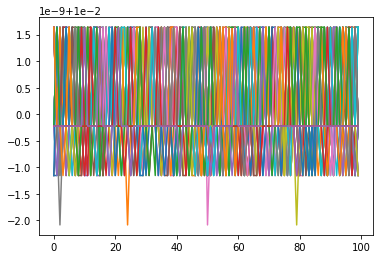

In [228]:
protein_attn_weights=""
for i in protein_attn_weights.mean(dim=2): #i is [100,100]
    plt.plot(i)


In [7]:
for i in _.mean(dim=2):
    plt.plot(i)
    #print(i)

AttributeError: 'str' object has no attribute 'mean'

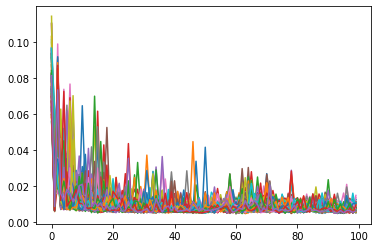

In [229]:
for i in _.mean(dim=1):
    plt.plot(i)
    #print(i)

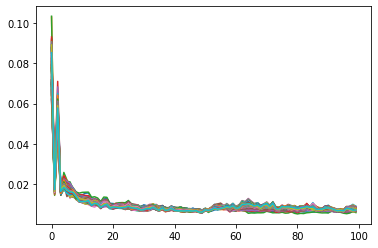

In [219]:
for i in _.mean(dim=-3):
    plt.plot(i)

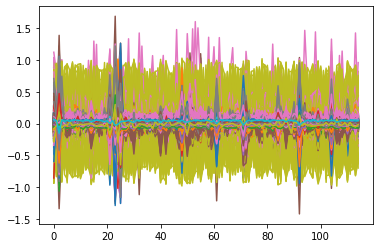

In [227]:
for i in ou:#.flatten():
    plt.plot(i)

In [202]:
_.mean(dim=0).shape

torch.Size([100, 100])

In [39]:
feats[:,0].shape

torch.Size([32, 1])

In [15]:
t.shape

torch.Size([1, 1, 1])